## ZFF Epoch Extraction

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as disp
import seaborn as sns
from scipy import signal
from scipy.signal import lfilter

sns.set_style('darkgrid')

22050


Text(0.5, 1.0, 'The input frame EGG')

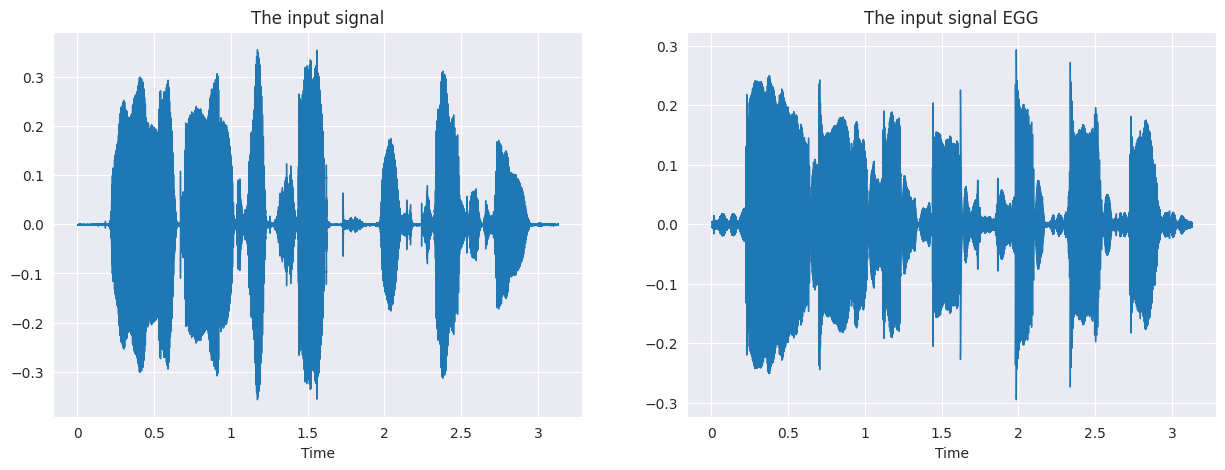

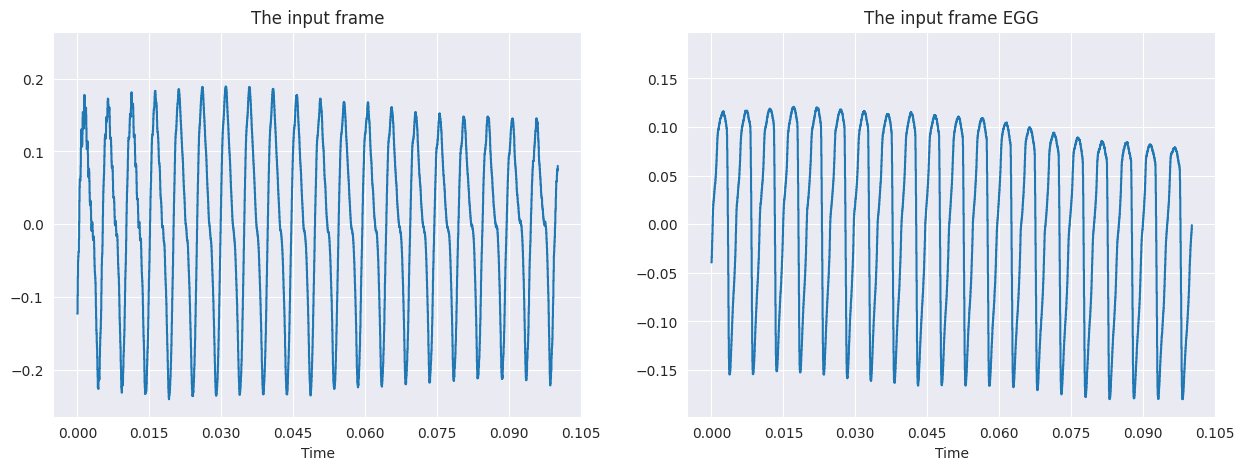

In [18]:
sound,fs = librosa.load('wav/arctic_b0539.wav',mono=False)
print(fs)
egg = sound[1]
sound = sound[0]
plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
plt.subplot(121)
disp.waveshow(sound) 
plt.title("The input signal")
plt.subplot(122)
disp.waveshow(egg)
plt.title("The input signal EGG" )

sound = sound[221*75:221*85]
egg = egg[221*75:221*85]

plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
plt.subplot(121)
disp.waveshow(sound) 
plt.title("The input frame")
plt.subplot(122)
disp.waveshow(egg)
plt.title("The input frame EGG" )




Text(0.5, 1.0, 'Passing twice through an ideal resonator')

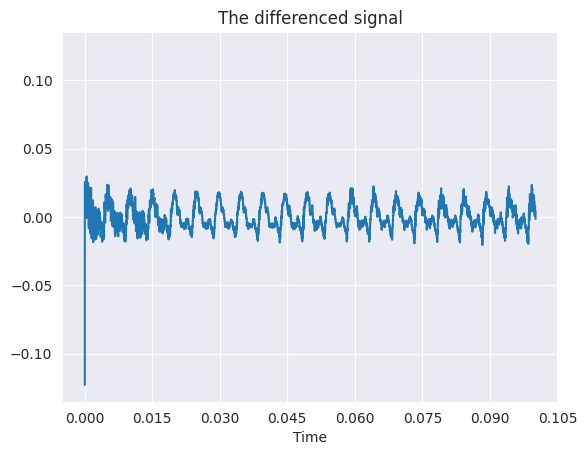

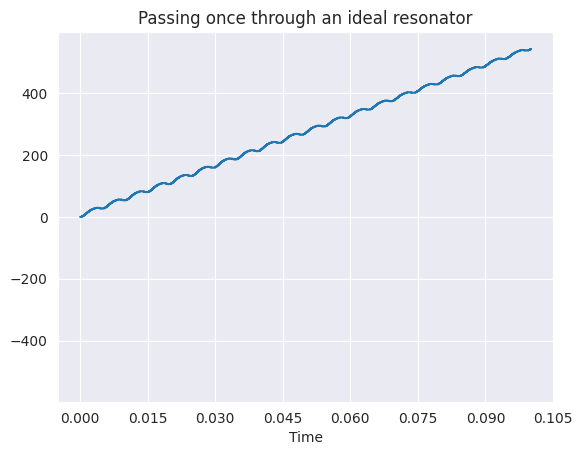

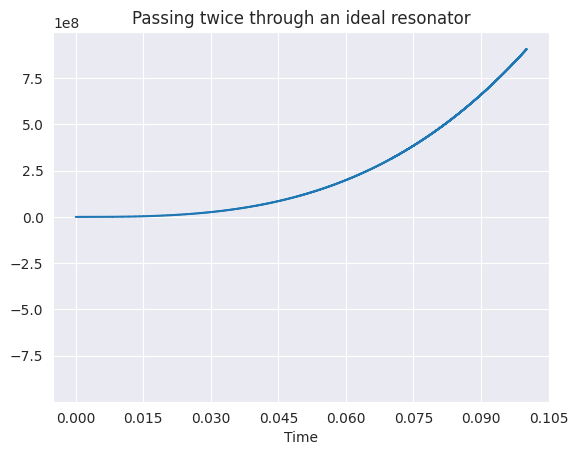

In [19]:
# Normalising
# sound = sound/np.max(sound)

# step 1
x_n = []
for n in range(len(sound)-1):
    if(n == 0):
        x_n.append(sound[n])
    else:
        x_n.append(sound[n] - sound[n-1])

x_n = np.array(x_n)
disp.waveshow(x_n)
plt.title("The differenced signal")

y1_n = []
#step 2
for n in range(len(sound)-1):
    if(n == 0):
        y1_n.append(x_n[n])
    else:
        y1_n.append((2 * y1_n[n-1]) - y1_n[n-2] + 2 * x_n[n])
# print(y1_n)
plt.figure()
y1_n = np.array(y1_n)
disp.waveshow(y1_n)
plt.title("Passing once through an ideal resonator")

#step 3
y2_n = []

for n in range(len(sound)-1):
    if(n == 0):
        y2_n.append(y1_n[n])
    else:
        y2_n.append((2 * y2_n[n-1]) - y2_n[n-2] + 2 * y1_n[n])

y2_n = np.array(y2_n)
plt.figure()
disp.waveshow(y2_n)
plt.title("Passing twice through an ideal resonator")



Text(0.5, 1.0, 'The differenced signal')

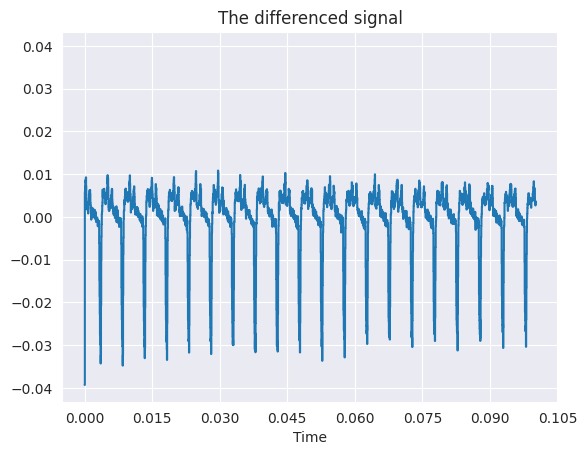

In [20]:
egg_diff = []
for n in range(len(egg)-1):
    if(n == 0):
        egg_diff.append(egg[n])
    else:
        egg_diff.append(egg[n] - egg[n-1])

egg_diff = np.array(egg_diff)
disp.waveshow(egg_diff)
plt.title("The differenced signal")

/home/user/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


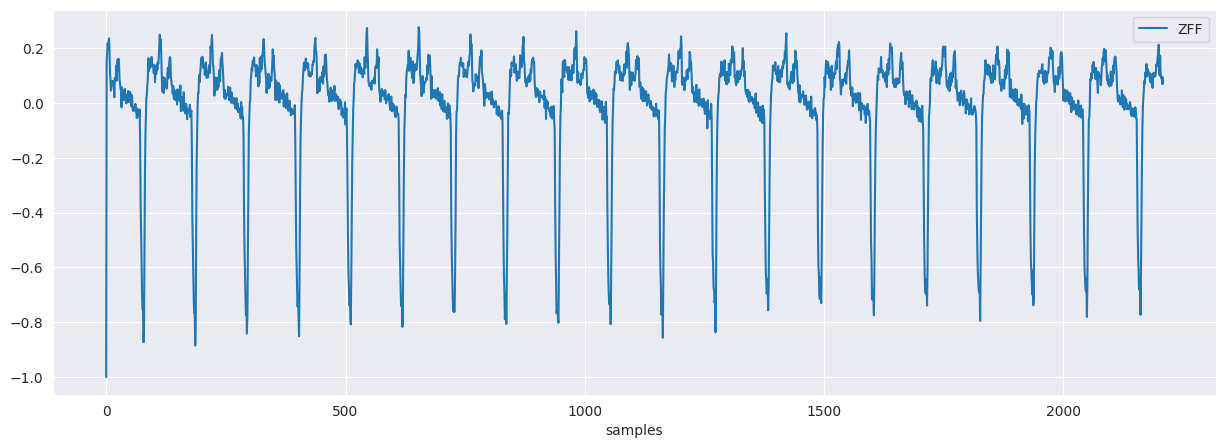

In [21]:
# mean subtraction
y_n = np.zeros(len(sound))
N = 110
padded = np.pad(y2_n,N)
for n in range(len(sound)-1):
    y_n[n-110] = y2_n[n-110] - np.mean(padded[n-N:n+N+1])


final = np.zeros(len(sound))

padded_2 = np.pad(y_n,N)
for n in range(len(sound)-1):
    final[n-110] = y_n[n-110] - np.mean(padded_2[n-N:n+N+1])

plt.figure(figsize=(15,5))
plt.xlabel("samples")
plt.plot(egg_diff/max(abs(egg_diff)))
plt.legend(["ZFF","differenced EGG"])

#shift

final_shift = np.zeros(len(sound)-6)
for n in range(len(final)-6):
    final_shift[n] = final[n+6]

# plt.plot(final_shift/max(final_shift))

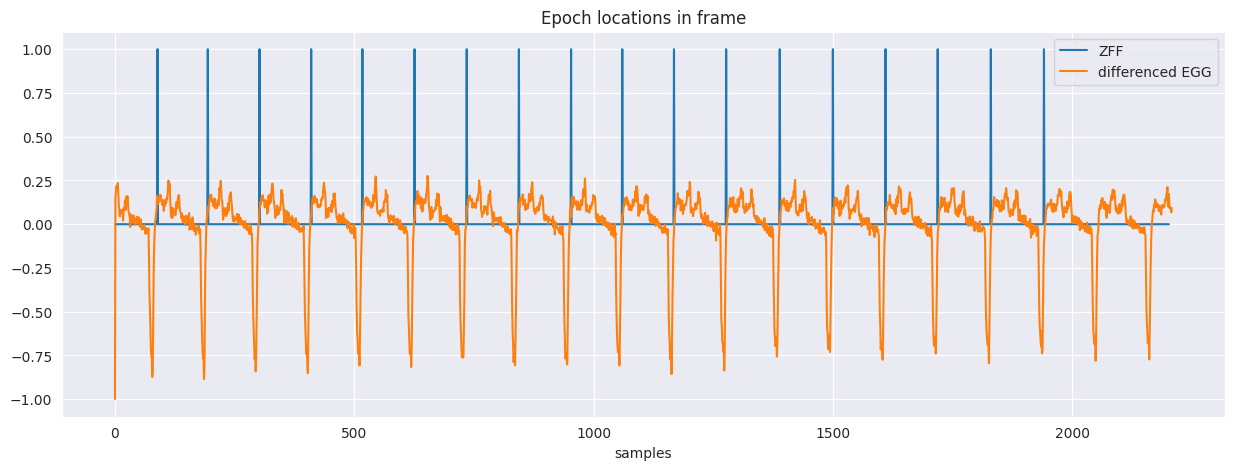

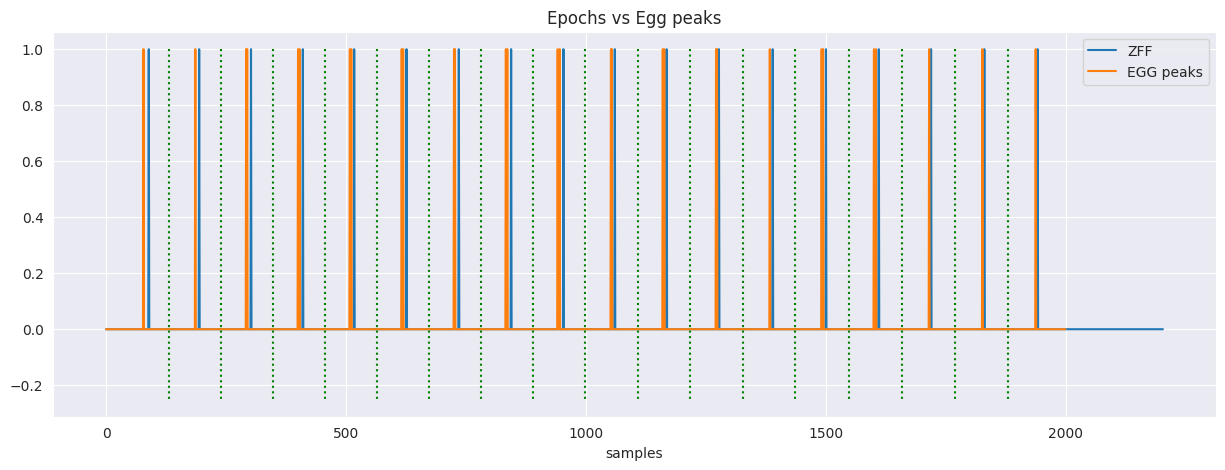

In [22]:
#noting down epoch locations.
# final_shift = final 
epoch = []
ind_epoch = []
for i in range(len(final_shift)-1):
    if(final_shift[i] * final_shift[i+1] < 0 and final_shift[i+1] > 0):
        epoch.append(1)
        ind_epoch.append(i)
    else:
        epoch.append(0)

plt.figure(figsize=(15,5))
plt.plot(epoch)
plt.title("Epoch locations in frame")
plt.xlabel("samples")
plt.plot(egg_diff/max(abs(egg_diff)))
plt.legend(["ZFF","differenced EGG"])

egg_diff = egg_diff[0:2000]

egg_peaks = np.zeros(len(egg_diff))
peaks = signal.find_peaks(abs(egg_diff),height=0.028)
egg_peaks[peaks[0]] = 1

plt.figure(figsize=(15,5))
plt.plot(epoch)
plt.plot(egg_peaks)
plt.xlabel("samples")
plt.title("Epochs vs Egg peaks")
plt.legend(["ZFF","EGG peaks"])
# Adding long dotted vertical lines
for i in range(len(peaks[0])):
    current_peak = peaks[0][i]
    # Check if there is a subsequent epoch and it's at least 53.5 samples away
    if i < len(peaks[0]) - 1 and peaks[0][i + 1] - current_peak >= 53.5:
        plt.vlines(current_peak + 53.5, ymin=1, ymax=-0.25, colors='g', linestyles='dotted')


In [23]:
print(peaks[0][0])
print(peaks[0][1])
print(peaks[0][2])
print(peaks[0][3])


78
186
292
294


In [24]:
print(peaks[0][0])
print(ind_epoch[0])

78
89


In [25]:
distances = []
for peak in peaks[0]:
    closest_error_peak = ind_epoch[np.argmin(np.abs(ind_epoch - peak))]
    distance = np.abs(peak - closest_error_peak)
    distances.append(distance)

# Print distances
print("Distances between actual peaks and closest identified peaks:")
print(distances)

# Calculate and print the average distance
average_distance = np.mean(distances)
print("Average distance:", average_distance)
print("\n")

# Convert distances from samples to milliseconds
distances_ms = np.array(distances) / fs * 1000

# Print distances in milliseconds
print("Distances between actual peaks and closest identified peaks (in ms):")
print(distances_ms)

# Convert average distance to milliseconds
average_distance_ms = average_distance / fs * 1000
print("Average distance (in ms):", average_distance_ms)


Distances between actual peaks and closest identified peaks:
[11, 8, 10, 8, 10, 7, 9, 6, 10, 7, 10, 8, 11, 8, 12, 8, 8, 6, 8, 5, 6, 4, 6, 9, 6, 10, 6, 4, 4, 4]
Average distance: 7.633333333333334


Distances between actual peaks and closest identified peaks (in ms):
[0.49886621 0.36281179 0.45351474 0.36281179 0.45351474 0.31746032
 0.40816327 0.27210884 0.45351474 0.31746032 0.45351474 0.36281179
 0.49886621 0.36281179 0.54421769 0.36281179 0.36281179 0.27210884
 0.36281179 0.22675737 0.27210884 0.1814059  0.27210884 0.40816327
 0.27210884 0.45351474 0.27210884 0.1814059  0.1814059  0.1814059 ]
Average distance (in ms): 0.34618291761148906


In [27]:
from scipy.signal import find_peaks

# Find zero crossings in the EGG signal
zero_crossings = np.where(np.diff(np.sign(egg)))[0]

# Find bottom peaks below -0.01 amplitude after each zero crossing
bottom_peaks = []
for crossing in zero_crossings:
    # Find peaks in the segment after each zero crossing
    segment = egg_diff[crossing:]
    neg_segment = -segment
    peaks, _ = find_peaks(neg_segment, height=-0.01)

    if len(peaks) > 0:
        # Consider only the first peak after the zero crossing
        bottom_peak_index = peaks[0] + crossing
        if egg_diff[bottom_peak_index] < 0:  # Check if the bottom peak is below 0
            bottom_peaks.append(bottom_peak_index)

# # Plot the EGG signal and mark the bottom peaks
# plt.figure(figsize=(10, 5))
# plt.plot(egg_diff, label='egg_diff signal')
# plt.plot(bottom_peaks, egg_diff[bottom_peaks], 'ro', label='Bottom Peaks')
# plt.legend()
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('EGG Signal Bottom Peaks on egg_diff below -0.01 amplitude after each zero crossing')
# plt.show()
egg_epochs = []
for i in range(len(egg) - 1):
    if egg[i] * egg[i + 1] < 0 and egg[i + 1] > 0:
        egg_epochs.append(i)

# Comparing the number of epochs detected
num_sound_epochs = sum(epoch)
num_egg_epochs = len(bottom_peaks)
print(f"Number of epochs detected in 'sound': {num_sound_epochs}")
print(f"Number of epochs detected in 'egg' signal: {num_egg_epochs}")
from tabulate import tabulate
sound_epochs = [i for i, value in enumerate(epoch) if value == 1]

# Calculate the distances between the individual epochs in milliseconds
epoch_distances = []
for epoch_index in sound_epochs:
    closest_eggs = [abs(epoch_index - egg_index) for egg_index in bottom_peaks]
    epoch_distances.append(min(closest_eggs))

# Average distance between epochs
avg_epoch_distance = np.mean(epoch_distances)

# Identification errors (distance between detected epoch and closest ground truth GCI)
identification_errors = []
for epoch_index in sound_epochs:
    closest_index = min(bottom_peaks, key=lambda x: abs(epoch_index - x))
    identification_errors.append(abs(epoch_index - closest_index))

# Identification Accuracy (IDA = standard deviation of identification errors)
identification_accuracy = np.std(identification_errors)



# Convert sample indices to milliseconds
ms_per_sample = 1000 / fs  # Calculate the duration of a single sample in milliseconds

# Individual distances between epochs and EGG in milliseconds
epoch_distances_ms = [distance * ms_per_sample for distance in epoch_distances]

total_distance = 0
count = 0
table_data = []

# print("Individual distances between epochs and EGG in milliseconds:")
for idx, distance in enumerate(epoch_distances_ms):
    # print(f"Epoch {idx + 1} distance: {distance:.2f} ms")
    table_data.append([f"Epoch {idx + 1}", f"{distance:.2f} ms"])
    total_distance += distance
    count += 1




# Average Identification Error
# avg_identification_error = np.mean(identification_errors)
avg_identification_error = total_distance / count

# Printing the table using tabulate
print(tabulate(table_data, headers=["Epoch", "Distance to EGG"], tablefmt="pretty"))

# print(f"Avg. distance between epochs and EGG in milliseconds: {avg_epoch_distance}")

print(f"\nAverage Identification Error: {avg_identification_error} ms")

print(f"\nStandard Deviation of Identification Errors (IDA): {identification_accuracy}")


Number of epochs detected in 'sound': 18
Number of epochs detected in 'egg' signal: 18
+----------+-----------------+
|  Epoch   | Distance to EGG |
+----------+-----------------+
| Epoch 1  |     0.50 ms     |
| Epoch 2  |     0.36 ms     |
| Epoch 3  |     0.45 ms     |
| Epoch 4  |     0.45 ms     |
| Epoch 5  |     0.41 ms     |
| Epoch 6  |     0.45 ms     |
| Epoch 7  |     0.45 ms     |
| Epoch 8  |     0.50 ms     |
| Epoch 9  |     0.36 ms     |
| Epoch 10 |     0.36 ms     |
| Epoch 11 |     0.36 ms     |
| Epoch 12 |     0.27 ms     |
| Epoch 13 |     0.41 ms     |
| Epoch 14 |     0.41 ms     |
| Epoch 15 |     0.45 ms     |
| Epoch 16 |     0.27 ms     |
| Epoch 17 |     0.27 ms     |
| Epoch 18 |     0.27 ms     |
+----------+-----------------+

Average Identification Error: 0.3905265810027715 ms

Standard Deviation of Identification Errors (IDA): 1.6712898840545916


## hidden

In [ ]:
from tabulate import tabulate

# Create a table for distances in milliseconds
table_ms = tabulate(enumerate(distances_ms), headers=['Index', 'Distance (ms)'], tablefmt='pretty')


print("Distances between actual peaks and closest identified peaks (in ms):")
print(table_ms)
print("\n")

average_distance_ms = np.mean(distances_ms)
print("Average distance (in ms):", average_distance_ms)


Distances between actual peaks and closest identified peaks (in ms):
+-------+---------------------+
| Index |    Distance (ms)    |
+-------+---------------------+
|   0   | 0.4988662131519275  |
|   1   | 0.36281179138321995 |
|   2   | 0.45351473922902497 |
|   3   | 0.36281179138321995 |
|   4   | 0.45351473922902497 |
|   5   | 0.31746031746031744 |
|   6   | 0.40816326530612246 |
|   7   | 0.27210884353741494 |
|   8   | 0.45351473922902497 |
|   9   | 0.31746031746031744 |
|  10   | 0.45351473922902497 |
|  11   | 0.36281179138321995 |
|  12   | 0.4988662131519275  |
|  13   | 0.36281179138321995 |
|  14   | 0.5442176870748299  |
|  15   | 0.36281179138321995 |
|  16   | 0.36281179138321995 |
|  17   | 0.27210884353741494 |
|  18   | 0.36281179138321995 |
|  19   | 0.22675736961451248 |
|  20   | 0.27210884353741494 |
|  21   | 0.18140589569160998 |
|  22   | 0.27210884353741494 |
|  23   | 0.40816326530612246 |
|  24   | 0.27210884353741494 |
|  25   | 0.45351473922902497 |
|  

In [ ]:
table_samples = tabulate(enumerate(distances), headers=['Index', 'Distance (samples)'], tablefmt='pretty')
print("Distances between actual peaks and closest identified peaks (in samples):")
print(table_samples)
print("\n")


Distances between actual peaks and closest identified peaks (in samples):
+-------+--------------------+
| Index | Distance (samples) |
+-------+--------------------+
|   0   |         11         |
|   1   |         8          |
|   2   |         10         |
|   3   |         8          |
|   4   |         10         |
|   5   |         7          |
|   6   |         9          |
|   7   |         6          |
|   8   |         10         |
|   9   |         7          |
|  10   |         10         |
|  11   |         8          |
|  12   |         11         |
|  13   |         8          |
|  14   |         12         |
|  15   |         8          |
|  16   |         8          |
|  17   |         6          |
|  18   |         8          |
|  19   |         5          |
|  20   |         6          |
|  21   |         4          |
|  22   |         6          |
|  23   |         9          |
|  24   |         6          |
|  25   |         10         |
|  26   |         6        

In [ ]:
table_data = list(enumerate(zip(distances, distances_ms), start=1))
headers = ["Index", "Distances (samples)", "Distances (ms)"]

# Print the table
print("Distances and Average Distance Table:")
print(tabulate(table_data, headers, tablefmt="grid"))

# Print the average distance in milliseconds separately
print("Average distance (in ms):", average_distance_ms)


Distances and Average Distance Table:
+---------+---------------------------+
|   Index | Distances (samples)       |
+=========+===========================+
|       1 | (11, 0.4988662131519275)  |
+---------+---------------------------+
|       2 | (8, 0.36281179138321995)  |
+---------+---------------------------+
|       3 | (10, 0.45351473922902497) |
+---------+---------------------------+
|       4 | (8, 0.36281179138321995)  |
+---------+---------------------------+
|       5 | (10, 0.45351473922902497) |
+---------+---------------------------+
|       6 | (7, 0.31746031746031744)  |
+---------+---------------------------+
|       7 | (9, 0.40816326530612246)  |
+---------+---------------------------+
|       8 | (6, 0.27210884353741494)  |
+---------+---------------------------+
|       9 | (10, 0.45351473922902497) |
+---------+---------------------------+
|      10 | (7, 0.31746031746031744)  |
+---------+---------------------------+
|      11 | (10, 0.45351473922902497) |
+-